In [22]:
import csv
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [23]:
options_dir = '../data/options_data'
for ticker in os.listdir(options_dir):
    ticker_dir = options_dir + '/' + ticker
    call_files = []
    for file in os.listdir(ticker_dir):
        file_heruistics = file.split('_')
        strike = file_heruistics[2].split('-', 1)
        expiry_date = datetime.strptime(file_heruistics[1], '%Y%m%d').date()

        if 'c' in strike[0].replace('.csv', ''):
            call_files.append((file, expiry_date))

    call_files.sort(key=lambda contract: contract[1])

    #implement covered call strategy
    balance = 100000
    ownUnderlying = False
    underlyingQuantity = 0 # in hundreds

    csv_data = []

    for file, expiry_date in call_files:
        print(file, expiry_date)
        with open(os.path.join(ticker_dir, file), 'r') as f:
            strike_csv = csv.reader(f)
            row = list(strike_csv)

            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                date = datetime.strptime(line[0], '%m/%d/%Y').date()
                if date.month == expiry_date.month:
                    start_open = float(row[index][1])
                    strike_price = float(row[index][16])
                    start_price = float(row[index][15])
                    end_price = float(row[1][15])
                    break

            # buy shares by the even hundreds + subtract balance
            if ownUnderlying == False:
                underlyingQuantity = math.floor(balance/(start_price * 100))
                balance -= (start_price * 100) * underlyingQuantity
                ownUnderlying = True

            # calculate profit of selling contract and add to balance
            contract_profit = underlyingQuantity * start_open * 100
            balance += contract_profit

            total_balance = balance + (underlyingQuantity * 100 * end_price)

            # obtain 'results'
            net_percentage = ((total_balance - 100000) / 100000) * 100
            net_return = total_balance - 100000

            csv_data.append([expiry_date, date, strike_price, start_price, end_price, start_open, underlyingQuantity, contract_profit, total_balance, net_percentage, net_return])

            # compare end asset price to strike price
            if end_price >= strike_price:
                stockSale = underlyingQuantity * 100 * end_price
                balance += stockSale

                ownUnderlying = False
                underlyingQuantity = 0

    with open('../data/outputs/covered_call/' + ticker + '.csv', 'w', newline="") as f:
        writer = csv.writer(f)

        header = ['Expiration Date', 'Date Contact Sold', 'Strike Price', 'Starting asset price', 'Ending Asset Price', 'Price Per Contract', 'Contracts Sold', 'Contract Profit', 'Monthly Ending Balance', 'Percent Change', 'Profit Amount']
        writer.writerow(header)

        for row in csv_data:
            writer.writerow(row)

price-history-for-msft_20191129_140.00c-11-22-2021.csv 2019-11-29
msft_20191227_150.00c.csv 2019-12-27
price-history-for-msft_20200131_155.00c-11-20-2021.csv 2020-01-31
price-history-for-msft_20200228_165.00c-11-20-2021.csv 2020-02-28
price-history-for-msft_20200327_160.00c-11-20-2021.csv 2020-03-27
msft_20200424_160.00c.csv 2020-04-24
price-history-for-msft_20200529_170.00c-11-20-2021.csv 2020-05-29
price-history-for-msft_20200626_185.00c-11-20-2021.csv 2020-06-26
price-history-for-msft_20200731_200.00c-11-22-2021.csv 2020-07-31
price-history-for-msft_20200828_215.00c-11-20-2021.csv 2020-08-28
historical-data-download-msft_20200925_225.00c-11-20-2021.csv 2020-09-25
price-history-for-msft_20201030_210.00c-11-20-2021.csv 2020-10-30
price-history-for-msft_20201127_205.00c-11-20-2021.csv 2020-11-27
price-history-for-msft_20201224_215.00c-11-20-2021.csv 2020-12-24
price-history-for-msft_20210129_220.00c-11-20-2021.csv 2021-01-29
price-history-for-msft_20210226_240.00c-11-20-2021.csv 2021-0

data points: 22
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021']
y-axis values: [101120.0, 109520.0, 110796.0, 100095.0, 59751.0, 73650.0, 77524.0, 103897.0, 123792.0, 129157.0, 144844.0, 171594.0, 206670.0, 209569.0, 232538.0, 259716.0, 287364.0, 302468.0, 357848.0, 361704.0, 349895.0, 337122.0]


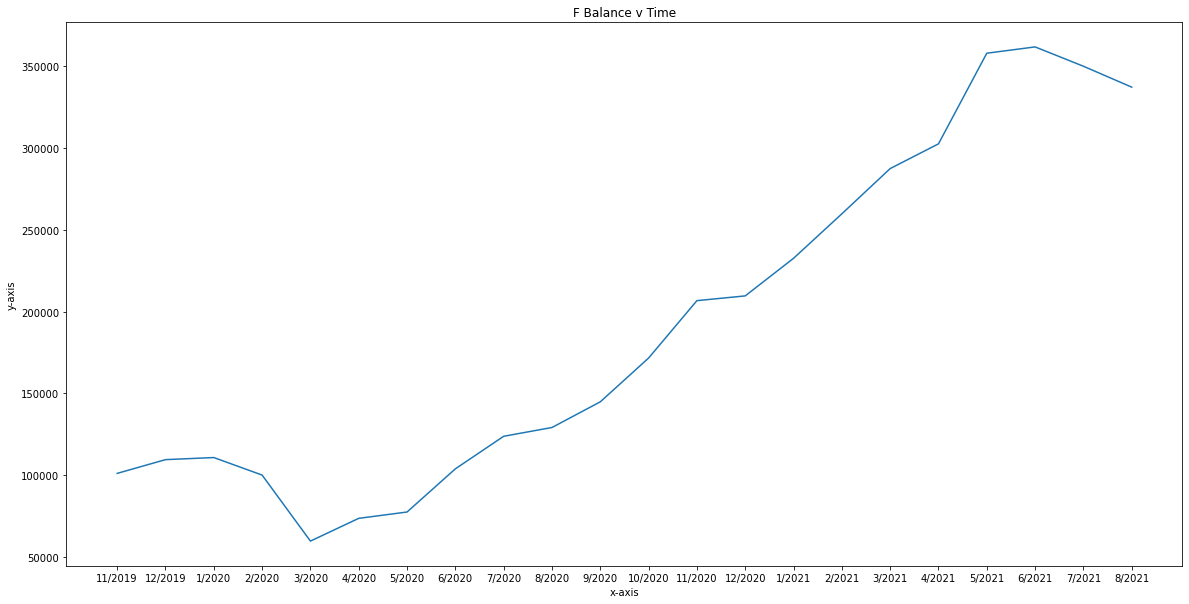

data points: 25
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [96048.0, 102418.0, 99421.0, 111706.0, 70056.0, 89831.0, 102347.0, 105862.0, 118084.0, 136300.0, 150520.0, 172521.0, 223432.0, 215832.0, 275182.0, 296276.0, 327398.0, 384996.0, 402948.0, 415128.0, 441658.0, 426398.0, 397278.0, 423178.0, 476977.0]


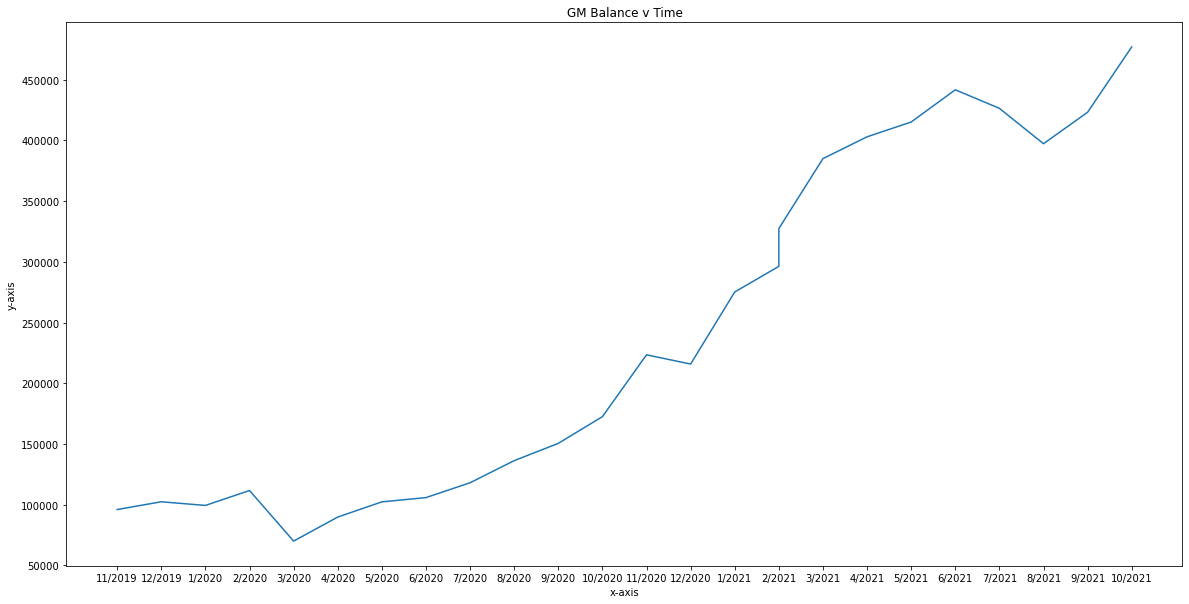

data points: 24
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [107596.0, 116738.0, 128050.0, 124886.0, 123969.0, 144619.0, 159419.0, 173379.0, 181107.0, 194563.0, 186443.0, 189803.0, 205971.0, 216807.0, 242718.0, 237518.0, 252238.0, 265968.0, 271208.0, 292048.0, 309558.0, 327708.0, 332728.0, 370118.0]


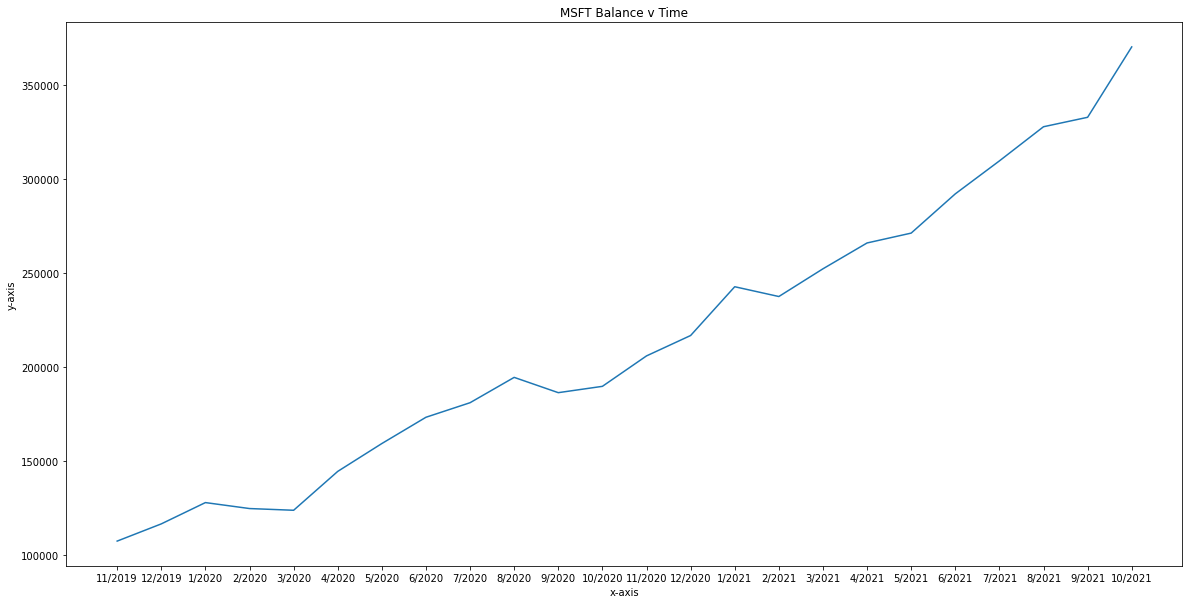

data points: 24
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [115092.0, 140467.0, 138227.0, 136771.0, 153851.0, 216046.0, 248941.0, 242179.0, 378477.0, 432381.0, 398939.0, 411037.0, 486017.0, 511133.0, 511353.0, 524938.0, 509263.0, 555243.0, 593953.0, 652426.0, 771658.0, 825405.0, 828855.0, 982455.0]


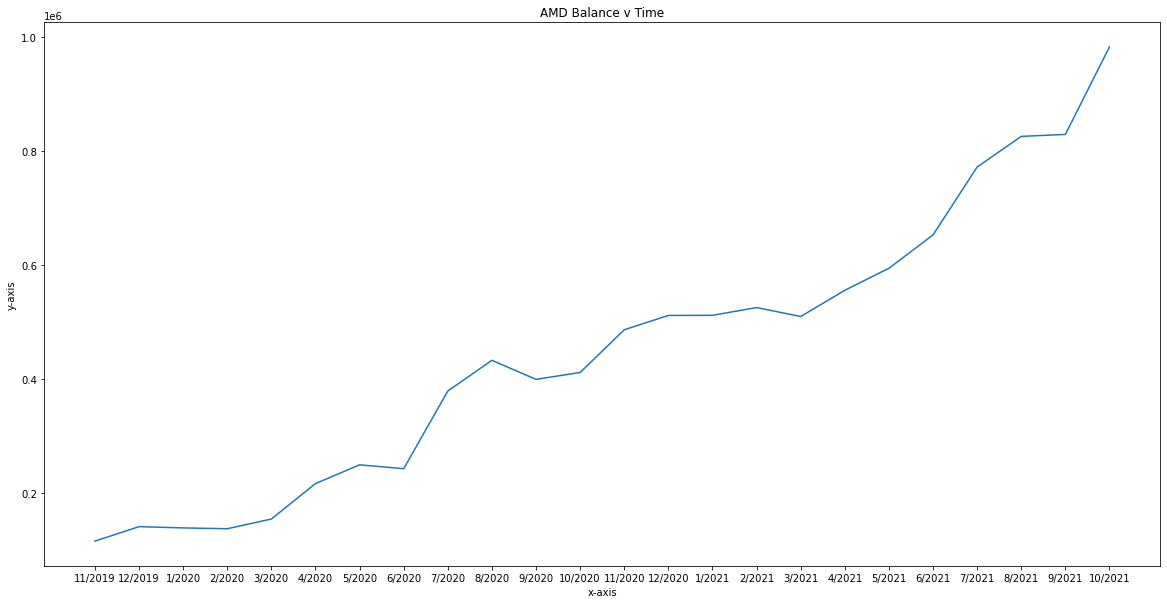

In [24]:
# graph results using matlab pyplot

outputs = '../data/outputs/covered_call/'
files = [f for f in os.listdir(outputs) if os.path.isfile(os.path.join(outputs, f))]

for file in files:
    with open(os.path.join(outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        
        profits = []
        monthly_balance = []
        months = []

        for line in rows[1:]:
            profits.append(round(float(line[10]), 2))
            monthly_balance.append(round(float(line[8]),2))
            date = datetime.strptime(line[0], "%Y-%m-%d").date()
            months.append(str(date.month) + '/' + str(date.year))
        
        print(file)
        print("data points: " + str(len(monthly_balance)))
        print('x-axis values: ' + str(months))
        print('y-axis values: ' + str(monthly_balance))

        x1 = months
        y1 = monthly_balance

        return_plt = plt.figure()
        return_plt.set_figheight(10)
        return_plt.set_figwidth(20)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.title(file.replace('.csv', '') + ' Balance v Time')
        plt.plot(x1, y1)
        plt.savefig('../data/outputs/covered_call/graphs/' + file.replace('.csv', '') + '_balance_v_time.jpg')
        plt.show()
        
